##### *Copyright 2021 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain EfficientDet for the Edge TPU with TensorFlow Lite Model Maker

<a href="https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_efficientdet_model_maker_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>
&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://github.com/google-coral/tutorials/blob/master/retrain_efficientdet_model_maker_tf2.ipynb" target="_parent"><img src="https://img.shields.io/static/v1?logo=GitHub&label=&color=333333&style=flat&message=View%20on%20GitHub" alt="View in GitHub"></a>


## Import the required packages

In [1]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 577 kB 4.6 MB/s 
     |████████████████████████████████| 60.9 MB 1.4 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 238 kB 88.8 MB/s 
     |████████████████████████████████| 1.3 MB 29.2 MB/s 
     |████████████████████████████████| 840 kB 81.7 MB/s 
     |████████████████████████████████| 10.9 MB 70.4 MB/s 
     |████████████████████████████████| 128 kB 86.0 MB/s 
     |████████████████████████████████| 3.4 MB 68.9 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 73.7 MB/s 
     |████████████████████████████████| 25.3 MB 73.4 MB/s 
     |████████████████████████████████| 497.9 MB 4.8 kB/s 
     |████████████████████████████████| 352 kB 84.1 MB/s 
     |████████████████████████████████| 5.8 MB 73.0 MB/s 
     |████████████████████████████████| 462 kB 73.5 MB/s 
     |████████████████████████████████| 1.4 MB 75.2 MB/s 
     |██████████

In [2]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Load the training data


If you want to train with your own image dataset, follow these steps:

1. Be sure your dataset is annotated in Pascal VOC XML (various tools can help create VOC annotations, such as [LabelImg](https://github.com/tzutalin/labelImg#labelimg)). Then create a ZIP file with all your JPG images and XML files (JPG and XML files can all be in one directory or in separate directories).
2. Click the **Files** tab in the left panel and just drag-drop your ZIP file there to upload it.
3. Use the following drop-down option to set **`use_custom_dataset`** to True.
4. If your dataset is already split into separate directories for training, validation, and testing, also set **`dataset_is_split`** to True. (If your dataset is not split, leave it False and we'll split it below.)
5. Then skip to [Load your own Pascal VOC dataset](#scrollTo=ZljJ25RAnj5x) and follow the rest of the instructions there.




In [3]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

dataset_is_split = True #@param ["False", "True"] {type:"raw"}

If you want to load your own dataset as a CSV file, you can learn more about the format in [Formatting a training data CSV](https://cloud.google.com/vision/automl/object-detection/docs/csv-format). You can load your CSV either from [Cloud Storage](https://cloud.google.com/storage) (as shown above) or from a local path.

[`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/DataLoader) can also load your dataset in other formats, such as from a set of TFRecord files or from a local directory using the Pascal VOC format (shown below for a custom dataset). 

### (Optional) Load your own Pascal VOC dataset

To use your custom dataset, you need to modify a few variables here, such as your ZIP filename, your label map, and the path to your images/annotations:

In [4]:
if use_custom_dataset:

  # The ZIP file you uploaded:
  !unzip 2aicardataset.zip

  # Your labels map as a dictionary (zero is reserved):
  label_map = {1: 'pedestrian', 2: 'stopsign', 3: 'redlight', 4: 'greenlight', 5: 'yellowlight'} 

  if dataset_is_split:
    # If your dataset is already split, specify each path:
    train_images_dir = 'aicardataset/train/images'
    train_annotations_dir = 'aicardataset/train/annotations'
    val_images_dir = 'aicardataset/validation/images'
    val_annotations_dir = 'aicardataset/validation/annotations'
    test_images_dir = 'aicardataset/test/images'
    test_annotations_dir = 'aicardataset/test/annotations'
  else:
    # If it's NOT split yet, specify the path to all images and annotations
    images_in = 'aicardataset/images'
    annotations_in = 'aicardataset/annotations'
  

Archive:  2aicardataset.zip
   creating: aicardataset/
   creating: aicardataset/test/
   creating: aicardataset/test/annotations/
  inflating: aicardataset/test/annotations/WIN_20221120_03_50_33_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_03_51_04_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_03_52_04_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_03_52_12_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_03_52_42_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_03_58_15_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_03_59_47_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_04_00_07_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_04_01_33_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_04_01_51_Pro.xml  
  inflating: aicardataset/test/annotations/WIN_20221120_04_10_03_Pro.xml  
  inflating: aicardataset/test/annotations/W

Now you're ready to train the model with your custom dataset. But before you run the notebook, you should also skip to the [Export to TensorFlow Lite](#scrollTo=_yB_XMpqGlLs) section and change the `TFLITE_FILENAME` and `LABLES_FILENAME` for your exported files.

Then run the whole notebook by clicking **Runtime > Run all**.

In [5]:
#@markdown Be sure you run this cell. It's hiding the `split_dataset()` function used in the next code block.

import os
import random
import shutil

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [6]:
# We need to instantiate a separate DataLoader for each split dataset
if use_custom_dataset:
  if dataset_is_split:
    train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)
  else:
    train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                                 val_split=0.2, test_split=0.2,
                                                 out_path='split-dataset')
    train_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(train_dir, 'images'),
        os.path.join(train_dir, 'annotations'), label_map=label_map)
    validation_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(val_dir, 'images'),
        os.path.join(val_dir, 'annotations'), label_map=label_map)
    test_data = object_detector.DataLoader.from_pascal_voc(
        os.path.join(test_dir, 'images'),
        os.path.join(test_dir, 'annotations'), label_map=label_map)
    
  print(f'train count: {len(train_data)}')
  print(f'validation count: {len(validation_data)}')
  print(f'test count: {len(test_data)}')

train count: 44
validation count: 44
test count: 44


## Select the model spec

Model Maker supports the EfficientDet-Lite family of object detection models that are compatible with the Edge TPU. (EfficientDet-Lite is derived from [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html), which offers state-of-the-art accuracy in a small model size). There are several model sizes you can choose from:

|| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|-|--------------------|-----------|---------------|----------------------|
|| EfficientDet-Lite0 | 5.7       | 37.4            | 30.4%               |
|| EfficientDet-Lite1 | 7.6       | 56.3            | 34.3%               |
|| EfficientDet-Lite2 | 10.2      | 104.6           | 36.0%               |
|| EfficientDet-Lite3 | 14.4      | 107.6           | 39.4%               |
| <td colspan=4><br><i>* File size of the compiled Edge TPU models. <br/>** Latency measured on a desktop CPU with a Coral USB Accelerator. <br/>*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.</i></td> |

Beware that the Lite2 and Lite3 models do not fit onto the Edge TPU's onboard memory, so you'll see even greater latency when using those, due to the cost of fetching data from the host system memory. Maybe this extra latency is okay for your application, but if it's not and you require the precision of the larger models, then you can [pipeline the model across multiple Edge TPUs](https://coral.ai/docs/edgetpu/pipeline/) (more about this when we compile the model below).

For this tutorial, we'll use Lite0:

In [7]:
basemodel = object_detector.EfficientDetLite1Spec()

The [`EfficientDetLite0Spec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/EfficientDetLite0Spec) constructor also supports several arguments that specify training options, such as the max number of detections (default is 25 for the TF Lite model) and whether to use Cloud TPUs for training. You can also use the constructor to specify the number of training epochs and the batch size, but you can also specify those in the next step.

## Create and train the model

Now we need to create our model according to the model spec, load our dataset into the model, specify training parameters, and begin training. 

Using Model Maker, we accomplished all of that with [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/create):

In [8]:
model = object_detector.create(train_data=train_data, 
                               model_spec=basemodel, 
                               validation_data=validation_data, 
                               epochs=200, 
                               batch_size=30, 
                               train_whole_model=True)

Epoch 1/200
1/1 [==============================] - 53s 53s/step - det_loss: 1.8228 - cls_loss: 1.1488 - box_loss: 0.0135 - reg_l2_loss: 0.0711 - loss: 1.8939 - learning_rate: 0.0080 - gradient_norm: 0.7436 - val_det_loss: 1.8083 - val_cls_loss: 1.1496 - val_box_loss: 0.0132 - val_reg_l2_loss: 0.0711 - val_loss: 1.8794
Epoch 2/200
1/1 [==============================] - 3s 3s/step - det_loss: 1.8203 - cls_loss: 1.1489 - box_loss: 0.0134 - reg_l2_loss: 0.0711 - loss: 1.8914 - learning_rate: 0.0375 - gradient_norm: 0.6833 - val_det_loss: 1.7867 - val_cls_loss: 1.1453 - val_box_loss: 0.0128 - val_reg_l2_loss: 0.0711 - val_loss: 1.8579
Epoch 3/200
1/1 [==============================] - 3s 3s/step - det_loss: 1.8095 - cls_loss: 1.1461 - box_loss: 0.0133 - reg_l2_loss: 0.0711 - loss: 1.8806 - learning_rate: 0.0375 - gradient_norm: 0.6445 - val_det_loss: 1.7541 - val_cls_loss: 1.1375 - val_box_loss: 0.0123 - val_reg_l2_loss: 0.0711 - val_loss: 1.8252
Epoch 4/200
1/1 [===========================

## Evaluate the model

Now we'll use the test dataset to evaluate how well the model performs with data it has never seen before.

The [`evaluate()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#evaluate) method provides output in the style of [COCO evaluation metrics](https://cocodataset.org/#detection-eval):

In [9]:
model.evaluate(test_data)

1/1 [==============================] - 9s 9s/step



{'AP': 0.75198203,
 'AP50': 0.99145705,
 'AP75': 0.93333054,
 'APs': -1.0,
 'APm': 0.7507513,
 'APl': 0.76203024,
 'ARmax1': 0.57375,
 'ARmax10': 0.81625,
 'ARmax100': 0.82,
 'ARs': -1.0,
 'ARm': 0.8183957,
 'ARl': 0.81289834,
 'AP_/pedestrian': 0.7598084,
 'AP_/stopsign': 0.87021303,
 'AP_/redlight': 0.7092621,
 'AP_/greenlight': 0.7229876,
 'AP_/yellowlight': 0.69763905}

## Export to TensorFlow Lite

Next, we'll export the model to the TensorFlow Lite format. By default, the [`export()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector/ObjectDetector#export) method performs [full integer post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization), which is exactly what we need for compatibility with the Edge TPU. (Model Maker uses the same dataset we gave to our model spec as a representative dataset, which is required for full-int quantization.)

We just need to specify the export directory and format. By default, it exports to TF Lite, but we also want a labels file, so we declare both:

In [10]:
TFLITE_FILENAME = 'efficientdet-lite-trafficrecognition.tflite'
LABELS_FILENAME = 'trafficobject-labels.txt'

In [11]:
model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

### Evaluate the TF Lite model

Exporting the model to TensorFlow Lite can affect the model accuracy, due to the reduced numerical precision from quantization and because the original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TF Lite model uses global NMS, which is faster but less accurate.

Therefore you should always evaluate the exported TF Lite model and be sure it still meets your requirements:

In [12]:
model.evaluate_tflite(TFLITE_FILENAME, test_data)

44/44 [==============================] - 250s 6s/step



{'AP': 0.72718483,
 'AP50': 0.9752073,
 'AP75': 0.9002711,
 'APs': -1.0,
 'APm': 0.72528195,
 'APl': 0.745437,
 'ARmax1': 0.56204545,
 'ARmax10': 0.7664773,
 'ARmax100': 0.7664773,
 'ARs': -1.0,
 'ARm': 0.7619628,
 'ARl': 0.7597321,
 'AP_/pedestrian': 0.7374827,
 'AP_/stopsign': 0.85408986,
 'AP_/redlight': 0.6752324,
 'AP_/greenlight': 0.70496136,
 'AP_/yellowlight': 0.66415775}

### Try the TFLite model

Just to be sure of things, let's run the model ourselves with an image from the test set. 

In [13]:
import random

# If you're using a custom dataset, we take a random image from the test set:
if use_custom_dataset:
  images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
  filenames = os.listdir(os.path.join(images_path))
  random_index = random.randint(0,len(filenames)-1)
  INPUT_IMAGE = os.path.join(images_path, filenames[random_index])
else:
  # Download a test image
  INPUT_IMAGE = 'test.jpg'
  DOWNLOAD_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg"
  !wget -q -O $INPUT_IMAGE $DOWNLOAD_URL

To simplify our code, we'll use the [PyCoral API](https://coral.ai/docs/reference/py/):

In [14]:
! python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 373 kB 1.7 MB/s 
     |████████████████████████████████| 1.5 MB 60.3 MB/s 


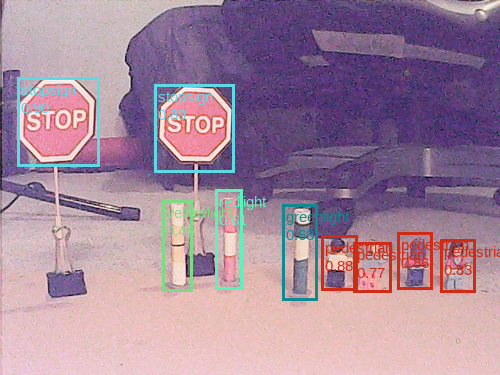

In [15]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

## Compile for the Edge TPU


First we need to download the Edge TPU Compiler:

In [16]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   117k      0 --:--:-- --:--:-- --:--:--  117k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 h

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [17]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler $TFLITE_FILENAME -d --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Searching for valid delegate with step 1
Try to compile segment with 322 ops
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed: Compilation failed due to large activation tensors in model.
Compilation child process completed within timeout period.
Compilation failed! 
Try to compile segment with 321 ops
Intermediate tensors: Sigmoid1,tfl.dequantize
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed: Compilation failed due to large activation tensors in model.
Compilation child process completed within timeout period.
Compilation failed! 
Try to compile segment with 320 ops
Intermediate tensors: concat_1,Sigmoid1
Started a compilation timeout timer of 180 seconds.
ERROR: Restored original execution plan after delegate application failure.
Compilation failed

**Beware when using multiple segments:** The Edge TPU Comiler divides the model such that all segments have roughly equal amounts of parameter data, but that does not mean all segments have the same latency. Especially when dividing an SSD model such as EfficientDet, this results in a latency-imbalance between segments, because SSD models have a large post-processing op that actually executes on the CPU, not on the Edge TPU. So although segmenting your model this way is better than running the whole model on just one Edge TPU, we recommend that you segment the EfficientDet-Lite model using our [profiling-based partitioner tool](https://github.com/google-coral/libcoral/tree/master/coral/tools/partitioner#profiling-based-partitioner-for-the-edge-tpu-compiler), which measures each segment's latency on the Edge TPU and then iteratively adjusts the segmentation sizes to provide balanced latency between all segments.

## Download the files

In [18]:
from google.colab import files

files.download(TFLITE_FILENAME)
files.download(TFLITE_FILENAME.replace('.tflite', '_edgetpu.tflite'))
files.download(LABELS_FILENAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run the model on the Edge TPU